In [446]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
from statsmodels.tsa.statespace.sarimax import SARIMAX
df = pd.read_pickle('model_df.pkl')

In [447]:
cutoff = datetime.strptime('2014-03-01','%Y-%m-%d')


In [448]:
final_GDP = df.GDP_interp.loc[df.chart_date==cutoff].values[0]
final_GDP

52642.28888888889

In [449]:

df['GDP_interp'] = df.GDP_interp.diff()
df['sentiment'] = df.sentiment.diff()

In [450]:
df['sentiment_L' + str(19)] = df.sentiment.shift(19,fill_value=0)
df.dropna(inplace=True)

In [451]:
test_df = df.loc[df.chart_date > cutoff]
train_df = df.loc[df.chart_date <= cutoff]
X_train = train_df.sentiment_L19
X_test = test_df.sentiment_L19
y_train = pd.DataFrame(train_df.GDP_interp)
y_test = pd.DataFrame(test_df.GDP_interp)

In [452]:
lags = 36 # number of lags for endogenous variable
order = ([3,6,9,12,15,18,21,24],1,[3,6,9,12,15,18,21,24])
seasonal = True
period = 4

In [453]:
model = SARIMAX(
        endog = y_train,
        lags=lags,
        exog=X_train,
        order=order,
        seasonal=seasonal,
        period=period)

c:\Users\kapta\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\kapta\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [454]:
model_fit = model.fit(maxiter=200)

c:\Users\kapta\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [455]:
model_fit.params

sentiment_L19      57.808258
ar.L3              -0.708808
ar.L6              -0.564603
ar.L9              -0.569172
ar.L12             -0.606137
ar.L15             -0.537348
ar.L18             -0.697746
ar.L21             -0.015876
ar.L24              0.041609
ma.L3               0.088015
ma.L6               0.168846
ma.L9               0.114568
ma.L12              0.185758
ma.L15             -0.026926
ma.L18              0.338185
ma.L21             -0.654594
ma.L24             -0.323093
sigma2           2305.116032
dtype: float64

In [456]:
exog = X_test

In [487]:
pd.DataFrame(model_fit.forecasts[0],columns=['predicted_mean'])

,predicted_mean
0,0.000000
1,104.347826
2,87.271739
3,84.277013
4,94.977114
...,...
660,79.377840
661,-96.073017
662,-99.220550
663,21.218520


In [494]:
y_pred = model_fit.forecast(len(exog),exog=exog)
y_pred = pd.concat([pd.DataFrame(model_fit.forecasts[0]),y_pred])
y_pred

c:\Users\kapta\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


,0
0,0.000000
1,104.347826
2,87.271739
3,84.277013
4,94.977114
...,...
764,44.159492
765,28.252437
766,40.498352
767,32.570379


In [458]:
ans_df = pd.DataFrame(y_pred).cumsum()+final_GDP
ans_df['chart_date'] = df.chart_date.iloc[len(X_train):len(df)-1]


In [499]:
og_df = pd.read_pickle('model_df.pkl')
og_df

,sentiment,GDP_interp,chart_date
date,,,
1958-09-01,0.169755,17381.652174,1958-09-01
1958-10-01,0.196548,17486.000000,1958-10-01
1958-11-01,0.204485,17573.271739,1958-11-01
1958-12-01,0.177540,17657.728261,1958-12-01
1959-01-01,0.186635,17745.000000,1959-01-01
...,...,...,...
2022-07-01,0.125863,60082.000000,2022-07-01
2022-08-01,0.045380,60082.000000,2022-08-01
2022-09-01,0.012304,60082.000000,2022-09-01


In [498]:
df['GDP_predict'] = y_pred.values
df['GDP_predict'] = df.GDP_predict.cumsum()
df

,sentiment,GDP_interp,chart_date,sentiment_L19,GDP_predict
date,,,,,
1958-10-01,0.026793,104.347826,1958-10-01,0.000000,0.000000
1958-11-01,0.007938,87.271739,1958-11-01,0.000000,104.347826
1958-12-01,-0.026945,84.456522,1958-12-01,0.000000,191.619565
1959-01-01,0.009095,87.271739,1959-01-01,0.000000,275.896578
1959-02-01,-0.000868,113.666667,1959-02-01,0.000000,370.873692
...,...,...,...,...,...
2022-07-01,0.236422,107.472527,2022-07-01,0.004151,40475.857234
2022-08-01,-0.080484,0.000000,2022-08-01,-0.084286,40504.109671
2022-09-01,-0.033076,0.000000,2022-09-01,0.109437,40544.608023


In [460]:
ans_df = pd.DataFrame(y_pred).cumsum()+final_GDP
ans_df['chart_date'] = df.tail(len(X_test)).chart_date.values
ans_df

,predicted_mean,chart_date
665,52814.277974,2014-04-01
666,52884.731381,2014-05-01
667,52966.047985,2014-06-01
668,53057.933788,2014-07-01
669,53124.391286,2014-08-01
...,...,...
764,57731.145773,2022-07-01
765,57759.398209,2022-08-01
766,57799.896562,2022-09-01
767,57832.466940,2022-10-01


In [461]:
og_df = pd.read_pickle('model_df.pkl')

In [462]:
predict_df = og_df.merge(right=ans_df,how='outer',on='chart_date')
predict_df.set_index('chart_date',drop=False)

,sentiment,GDP_interp,chart_date,predicted_mean
chart_date,,,,
1958-09-01,0.169755,17381.652174,1958-09-01,NaN
1958-10-01,0.196548,17486.000000,1958-10-01,NaN
1958-11-01,0.204485,17573.271739,1958-11-01,NaN
1958-12-01,0.177540,17657.728261,1958-12-01,NaN
1959-01-01,0.186635,17745.000000,1959-01-01,NaN
...,...,...,...,...
2022-07-01,0.125863,60082.000000,2022-07-01,57731.145773
2022-08-01,0.045380,60082.000000,2022-08-01,57759.398209
2022-09-01,0.012304,60082.000000,2022-09-01,57799.896562


<AxesSubplot:xlabel='chart_date'>

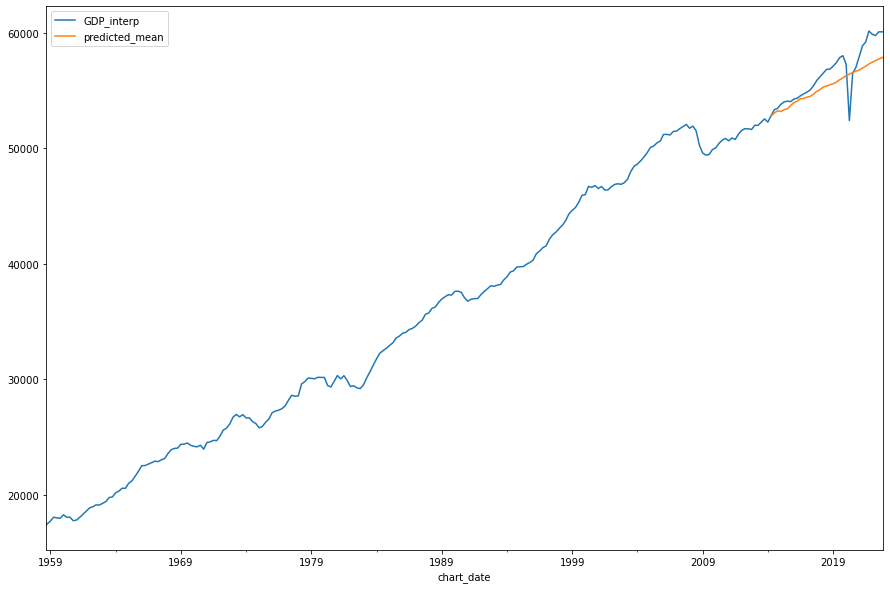

In [474]:
predict_df.plot(x='chart_date',y=['GDP_interp','predicted_mean'],figsize=(15,10))

<AxesSubplot:>

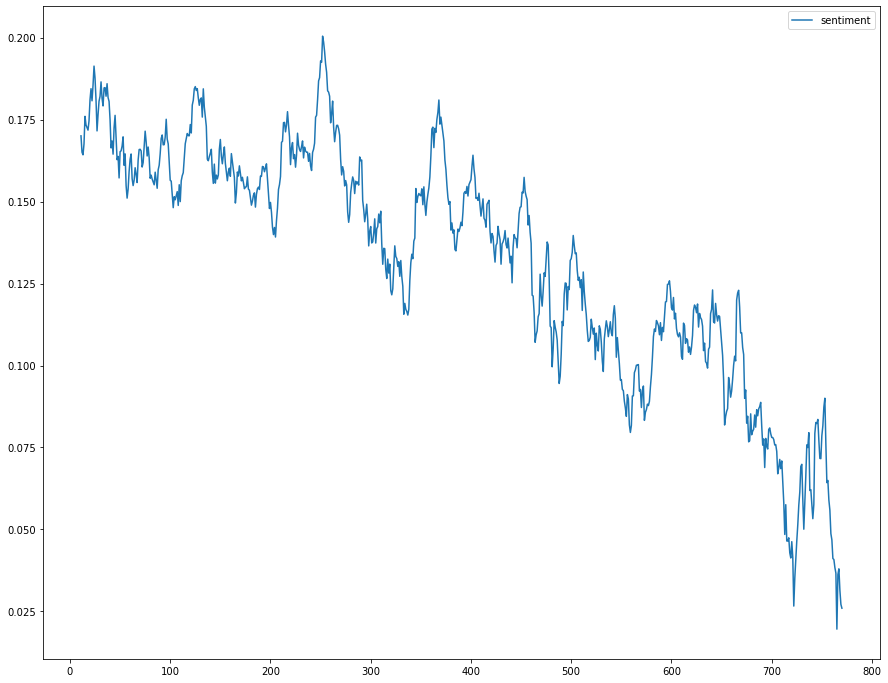

In [472]:
pd.DataFrame(predict_df.sentiment).rolling(window=12).mean().plot(figsize=(15,12),use_index=True)